In [163]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import kmapper as km
from kmapper.jupyter import display
import umap
import sklearn.manifold as manifold

import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## Unsupervised Learning

In [2]:
# Define base file path
file_path = '~/Desktop/Football Analysis Project/'

# Read team, competition and player datasets
teams = pd.read_json(file_path + "teams.json")
competitions = pd.read_json(file_path + "competitions.json")
players = pd.read_json(file_path + "players.json")
playerank = pd.read_json(file_path + "playerank.json")

# Read in match events for every competition
events_World_Cup = pd.read_json(file_path + "events/events_World_Cup.json")
events_England = pd.read_json(file_path + "events/events_England.json")
events_European_Championship = pd.read_json(file_path + "events/events_European_Championship.json")
events_France = pd.read_json(file_path + "events/events_France.json")
events_Germany = pd.read_json(file_path + "events/events_Germany.json")
events_Italy = pd.read_json(file_path + "events/events_Italy.json")
events_Spain = pd.read_json(file_path + "events/events_Spain.json")

# Read in event and tag id mappings
event_mapping = pd.read_csv(file_path + "eventid2name.csv")
tags_mapping = pd.read_csv(file_path + "tags2name.csv")

In [3]:
# Merge all events
all_events = [
    events_World_Cup,
    events_England,
    events_European_Championship,
    events_France,
    events_Germany,
    events_Italy,
    events_Spain
]

# Concatenate all DataFrames vertically (axis=0)
combined_events = pd.concat(all_events, axis=0, ignore_index=True)

In [4]:
# Look at combined dataset
combined_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],122671,"[{'y': 50, 'x': 50}, {'y': 53, 'x': 35}]",2057954,Pass,16521,1H,1.656214,85,258612104
1,8,High pass,[{'id': 1801}],139393,"[{'y': 53, 'x': 35}, {'y': 19, 'x': 75}]",2057954,Pass,16521,1H,4.487814,83,258612106
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",103668,"[{'y': 81, 'x': 25}, {'y': 83, 'x': 37}]",2057954,Duel,14358,1H,5.937411,10,258612077
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",122940,"[{'y': 19, 'x': 75}, {'y': 17, 'x': 63}]",2057954,Duel,16521,1H,6.406961,10,258612112
4,8,Simple pass,[{'id': 1801}],122847,"[{'y': 17, 'x': 63}, {'y': 15, 'x': 71}]",2057954,Pass,16521,1H,8.562167,85,258612110


In [5]:
# Convert playerank into minutes played for each player
playerminutes = playerank.drop(['goalScored','matchId'],axis = 1)
playerminutes = playerminutes.groupby('playerId').agg({
    'roleCluster': lambda x: set(x),  # Collect unique roles as a set
    'minutesPlayed': 'sum',            # Sum all minutes played
    'playerankScore': lambda x: np.mean(x)
}).reset_index()  # Optional: Convert 'playerId' back to a column

In [6]:
# Look at first few rows
playerminutes.head()

,playerId,roleCluster,minutesPlayed,playerankScore
0,12,{left CB},180,0.010700
1,36,"{right CB, right MF, left CB}",2160,0.008550
2,38,{left MF},347,0.001000
3,45,{right MF},288,0.001180
4,48,"{left MF, left CB, central MF-left CB, left CB...",4104,0.011824


In [7]:
# Inner join players and events
full_df = pd.merge(combined_events, players ,left_on = "playerId", right_on = "wyId", how = "inner")

# Drop unnecessary columns
full_df = full_df.drop(['eventId','matchId','matchPeriod','eventSec','firstName','lastName',
                                 'birthDate','birthArea','wyId','foot','currentNationalTeamId','id',
                                 'passportArea','weight','middleName'], axis = 1)

full_df.head()

,subEventName,tags,playerId,positions,eventName,teamId,subEventId,currentTeamId,height,role,shortName
0,Simple pass,[{'id': 1801}],122671,"[{'y': 50, 'x': 50}, {'y': 53, 'x': 35}]",Pass,16521,85,16470,179,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...",Mohammad Al Sahlawi
1,High pass,[{'id': 1801}],139393,"[{'y': 53, 'x': 35}, {'y': 19, 'x': 75}]",Pass,16521,83,16467,177,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",Abdullah Otayf
2,Air duel,"[{'id': 703}, {'id': 1801}]",103668,"[{'y': 81, 'x': 25}, {'y': 83, 'x': 37}]",Duel,14358,10,13888,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",I. Kutepov
3,Air duel,"[{'id': 701}, {'id': 1802}]",122940,"[{'y': 19, 'x': 75}, {'y': 17, 'x': 63}]",Duel,16521,10,16467,170,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",Yasir Al Shahrani
4,Simple pass,[{'id': 1801}],122847,"[{'y': 17, 'x': 63}, {'y': 15, 'x': 71}]",Pass,16521,85,16467,179,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",Salman Al Faraj


Now that we have a combined dataset containing all match events and any relevant information, we need to find normalized metrics that allows our model to determine clusters and natural groups between players. Thus, a list of per 90 minute stats that could be useful and are found in the dataset: Air Duels/90, Defensive Ground Duels/90, Accelerations/90, Touch/90, Cross/90, Saves/90, Goalkeeper Leaving Line per 90, Long Pass/90, Short Pass/90, Shots/90, Fouls/90, Others on the Ball/90, Clearances/90, Save Attempt per 90, Take Ons/90, Dribbles/90, Interceptions/90. Additional metrics such as distance traveled could also be useful, but are not available in the dataset.

In [8]:
def extract_count(df, subevents, tag_list = None):
    """
    Extracts and counts player occurrences for specific subevents and optional tags.
    
    Parameters:
    - df (DataFrame): Input dataframe containing event data
    - subevents (list): List of subevent names to filter on
    - tag_list (list, optional): List of tag IDs to filter on. Defaults to None.
    
    Returns:
    - Series: Counts of events per playerId, filtered by subevents and tags (if provided)
    """
    
    # Keep only relevant columns from the input dataframe
    df = df[["subEventName","tags","playerId"]]
    
    # Helper function to extract relevant tags from the tags column
    def extract_relevant_tags(tags):
        """Extracts tag IDs that are present in the provided tag_list"""
        return [tag['id'] for tag in tags if tag['id'] in tag_list]

    # Filter dataframe to only include rows with the specified subevents
    filtered_df = df[df["subEventName"].isin(subevents)].copy()
    
    if (tag_list is not None):
        # If tag_list is provided:
        # 1. Extract relevant tags from each row's tags
        filtered_df['tag_ids'] = filtered_df['tags'].apply(extract_relevant_tags)
        # 2. Explode the list of tags so each tag gets its own row
        exploded_df = filtered_df.explode('tag_ids')
        # 3. Count occurrences per player
        event_counts = exploded_df.groupby('playerId').size().rename('count')
    else:
        # If no tag_list provided, simply count subevent occurrences per player
        event_counts = filtered_df.groupby('playerId').size().rename('count')
        
    return event_counts

In [9]:
# Extract player counts for each statistic
airDuelsCount = extract_count(full_df, ["Air duel"])
groundDefendingDuelsCount = extract_count(full_df, ["Ground defending duel"])
takeOnDuelsCount = extract_count(full_df, ["Ground attacking duel"])
groundLooseBallDuelsCount = extract_count(full_df, ["Ground loose ball duel"])
accelerationsCount = extract_count(full_df, ["Acceleration"])
interceptionCount = extract_count(full_df, ["Touch"], [1402])
crossCount = extract_count(full_df, ["Cross"])
goalKickCount = extract_count(full_df, ["Goal kick"])
longPassCount = extract_count(full_df, ["High pass", "Launch"])
shortPassCount = extract_count(full_df, ["Simple pass","Head pass"])
smartPassCount = extract_count(full_df, ["Smart pass"])
shotCount = extract_count(full_df, ["Shot"])
clearancesCount = extract_count(full_df, ["Clearance"])

In [10]:
# Create a DataFrame from each series, preserving their indices (playerIds)
stats_data = {
    'airDuels': airDuelsCount,
    'groundDefendingDuels': groundDefendingDuelsCount,
    'takeOnDuels': takeOnDuelsCount,
    'groundLooseBallDuels': groundLooseBallDuelsCount,
    'accelerations': accelerationsCount,
    'interceptions': interceptionCount,
    'crosses': crossCount,
    'goalKicks': goalKickCount,
    'longPasses': longPassCount,
    'shortPasses': shortPassCount,
    'smartPasses': smartPassCount,
    'shots': shotCount,
    'clearances': clearancesCount
}

# Convert to DataFrame with playerId as index
stats_df = pd.DataFrame(stats_data)

# Merge with minutes data (keeping all players from stats_df)
combined_df = pd.merge(
    stats_df.reset_index().rename(columns={'index': 'playerId'}),
    playerminutes,
    on='playerId',
    how='left'
)

# Fill missing minutes with 0 and handle NaNs
combined_df['minutesPlayed'] = combined_df['minutesPlayed'].fillna(0)

# Calculate per90 metrics
metrics = stats_data.keys()
per90_data = {}

for metric in metrics:
    # Fill NaN in the metric with 0 first
    combined_df[metric] = combined_df[metric].fillna(0)
    
    # Calculate per90 (0 when minutes = 0)
    per90_data[f'{metric}_per90'] = np.where(
        combined_df['minutesPlayed'] > 0,
        combined_df[metric] / (combined_df['minutesPlayed'] / 90),
        0
    )

# Create final DataFrame with only player info and per90 stats
final_df = pd.DataFrame({
    'playerId': combined_df['playerId'],
    'roleCluster': combined_df['roleCluster'].fillna('Unknown'),
    'minutesPlayed': combined_df['minutesPlayed'],
    'playerankScore': combined_df['playerankScore']
})

# Add all per90 metrics
final_df = pd.concat([
    final_df,
    pd.DataFrame(per90_data)
], axis=1)

# Round per90 metrics to 2 decimals and fill any remaining NaNs
per90_cols = [col for col in final_df.columns if '_per90' in col]
final_df[per90_cols] = final_df[per90_cols].round(2).fillna(0)

# Filter columns to only keep player info and per90 stats
final_df = final_df[['playerId', 'minutesPlayed', 'playerankScore'] + per90_cols]

# Merge data with players to get name, role and height
final_df = pd.merge(final_df, players[['wyId','shortName', 'role', 'height']], left_on = 'playerId', right_on= 'wyId', how = 'left')
final_df = final_df.drop('wyId', axis = 1)

# Retrieve positional tag
final_df["role"] = final_df["role"].apply(lambda x: x.get("code2"))

original_length = len(final_df)

In [11]:
# Drop rows with 'GK' as position as no minutes available as well as any players with less than 300 minutes played
final_df = final_df[final_df["role"] != 'GK'] 
final_df = final_df[final_df["minutesPlayed"] >= 300] 
new_length = len(final_df)
print(f'Before dropping: {original_length} samples')
print(f'After dropping: {new_length} samples')
print(f'Rows dropped: {original_length - new_length} samples')

Before dropping: 3033 samples
After dropping: 1982 samples
Rows dropped: 1051 samples


## EDA

Now we want to see if there are any major imbalances/problems that need to be address. 

In [12]:
# Summary statistics for our data
final_df.describe()

,playerId,minutesPlayed,playerankScore,airDuels_per90,groundDefendingDuels_per90,takeOnDuels_per90,groundLooseBallDuels_per90,accelerations_per90,interceptions_per90,crosses_per90,goalKicks_per90,longPasses_per90,shortPasses_per90,smartPasses_per90,shots_per90,clearances_per90,height
count,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000
mean,102259.490414,1705.654390,0.006265,4.075888,6.514854,6.897841,3.538633,0.676978,4.347064,1.624591,0.001130,3.480469,34.020313,0.764793,1.123052,1.394879,181.751766
std,125565.456101,871.882832,0.007168,2.848926,2.245760,4.934570,1.362029,0.625850,1.174444,1.522224,0.014321,2.323880,13.320152,0.702152,0.893363,1.132675,6.227873
min,36.000000,301.000000,-0.020267,0.000000,1.030000,0.230000,0.750000,0.000000,1.240000,0.000000,0.000000,0.000000,8.910000,0.000000,0.000000,0.000000,162.000000
25%,14760.500000,957.500000,0.001650,2.270000,4.870000,2.842500,2.600000,0.200000,3.520000,0.390000,0.000000,1.512500,24.542500,0.260000,0.400000,0.490000,178.000000
50%,26009.000000,1659.500000,0.006238,3.410000,6.500000,5.830000,3.300000,0.500000,4.260000,1.160000,0.000000,3.260000,32.180000,0.590000,0.860000,1.020000,182.000000
75%,209184.500000,2385.500000,0.010885,4.940000,8.090000,10.075000,4.120000,0.997500,5.040000,2.490000,0.000000,5.007500,40.935000,1.060000,1.720000,2.120000,186.000000
max,523089.000000,4334.000000,0.043685,24.770000,16.260000,26.800000,11.490000,4.750000,10.000000,11.420000,0.450000,13.240000,97.520000,6.000000,5.420000,5.670000,203.000000


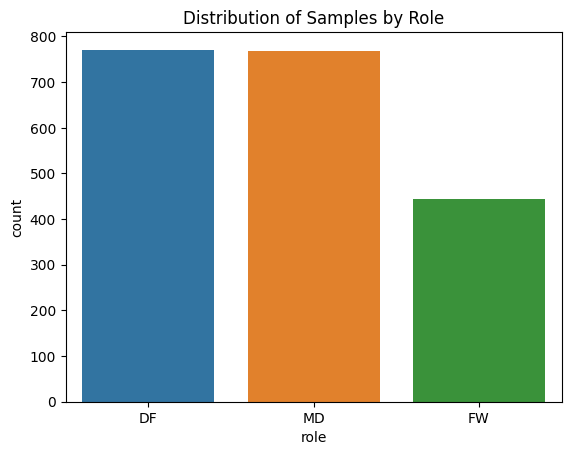

In [13]:
# Plot number of samples for each class
sns.countplot(final_df, x = 'role')
plt.title('Distribution of Samples by Role')
plt.show()

Our class imbalance is not too bad, and a good clustering algorithm should be able to deal with it. This may become a problem that needs to be addressed in the following classification task, but for now it is adequate. We see that the range for each feature is varying, some in the tens, some in the single digits, so we address this by standardizing each variable between 0-1.

In [14]:
# Drop classes from our final training dataset
train = final_df.drop(['playerId','minutesPlayed', 'shortName', 'role'], axis = 1)

In [15]:
# Standardize our features
scaler = StandardScaler()
train = scaler.fit_transform(train)

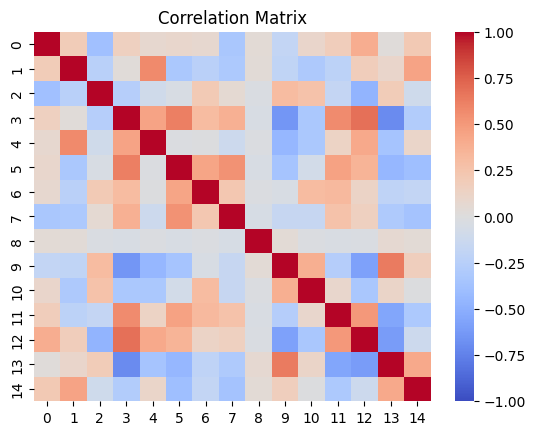

In [16]:
# Look for independent variables that are redundant with high covariance
corr_matrix = np.corrcoef(train, rowvar = False)
#upper_tri = corr_matrix.where(np.triu(np.ones_like(corr_matrix), k=1).astype(bool))
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]  # Threshold
#df_reduced = df.drop(to_drop, axis=1)
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [17]:
def drop_redundant_features(X, threshold=0.95):
    """
    Identifies and drops highly correlated (redundant) features from a dataset.
    
    Parameters:
    - X (numpy.ndarray): Input feature matrix (2D array)
    - threshold (float): Correlation threshold above which features are considered redundant (default: 0.95)
    
    Returns:
    - tuple: (filtered feature matrix with redundant columns removed, indices of kept columns)
    """
    
    # Calculate pairwise correlation matrix between all features
    # rowvar=False treats columns as variables (features) and rows as observations
    corr_matrix = np.corrcoef(X, rowvar=False)

    # Set diagonal (self-correlation) to 0 to avoid comparing features with themselves
    np.fill_diagonal(corr_matrix, 0)
    
    # Find all pairs of features where absolute correlation exceeds the threshold
    # Returns array of (i,j) index pairs where corr_matrix[i,j] > threshold
    redundant_pairs = np.column_stack(np.where(np.abs(corr_matrix) > threshold))
    print("Redundant feature pairs (indices):", redundant_pairs)
    
    # Determine which features to drop (keeping only one from each highly correlated pair)
    to_drop = set()
    for i, j in redundant_pairs:
        # If feature i hasn't been marked for dropping yet, mark feature j for dropping
        # This ensures we keep at least one feature from each correlated pair
        if i not in to_drop:
            to_drop.add(j)
    
    # Create list of column indices to keep (all columns not in to_drop set)
    keep_columns = [col for col in range(X.shape[1]) if col not in to_drop]
    
    # Return filtered feature matrix and list of kept column indices
    return X[:, keep_columns], keep_columns

train_filtered, kept_cols = drop_redundant_features(train, threshold=0.7)

Redundant feature pairs (indices): []


No features were found to be redundant.

## Unsupervised Model Training

In [18]:
# Create PCA object and train on filtered dataset
pca = PCA()
pca.fit(train_filtered)

PCA()

In [19]:
# Look at how much variance is explained by each principal component
pca.explained_variance_ratio_

array([0.30061182, 0.18894998, 0.10327089, 0.076811  , 0.06621084,
       0.05710069, 0.0404311 , 0.03232862, 0.03022738, 0.02609421,
       0.02196756, 0.01856372, 0.01570855, 0.01148175, 0.0102419 ])

Text(0, 0.5, 'Cumulative Explained Variance')

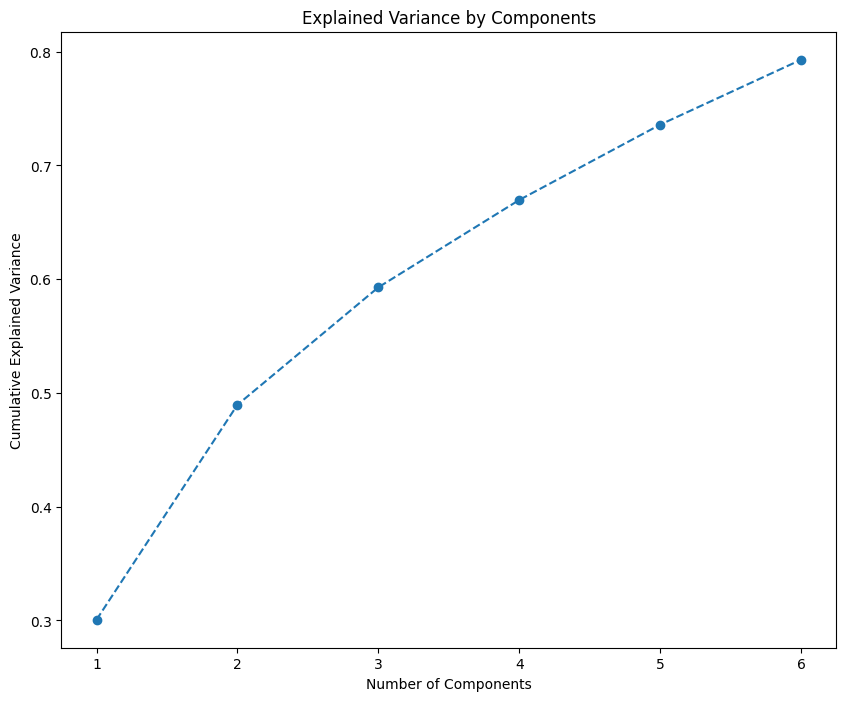

In [80]:
# Plot cumulative explained variance versus number of components
plt.figure(figsize = (10,8))
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [81]:
# Train and fit PCA model with number of components that explains around 80% of variance
pca = PCA(n_components = 6).fit(train_filtered)

# Transform data
pca_train = pca.transform(train_filtered)

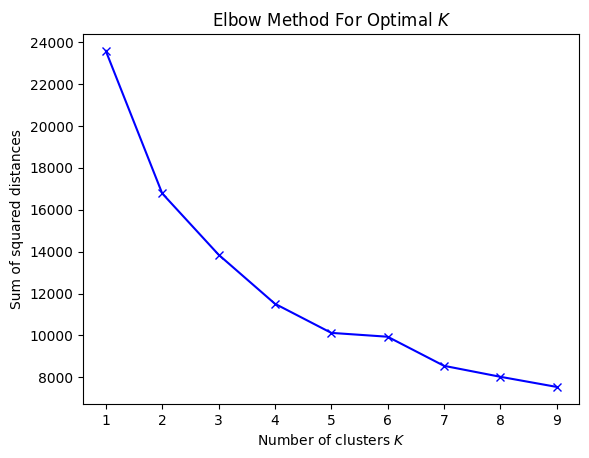

In [82]:
# Search for "optimal" number of clusters
SS_dist = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, n_init = 10)
    kmeans.fit(pca_train)
    SS_dist.append(kmeans.inertia_)
plt.plot(K,SS_dist,'bx-')
plt.xlabel('Number of clusters $K$') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow Method For Optimal $K$')
plt.show()

In [83]:
# Rerun KMeanswith optimal number of clusters
# Cheating a bit because we know how we want the data to be grouped
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42, n_init = 10).fit(pca_train)

In [157]:
# Fit DBSCAN
dbscan = DBSCAN(eps = 1, min_samples = 35).fit(pca_train)

In [158]:
# Create DataFrame with original labels, PCA components and clustering groups
df_segm_pca = pd.concat([final_df.reset_index(drop = True), pd.DataFrame(pca_train)], axis = 1)
df_segm_pca.columns.values[-6:] = ['Comp 1', 'Comp 2', 'Comp 3', 'Comp 4', 'Comp 5','Comp 6']
df_segm_pca["KMeans PCA Labels"] = kmeans_pca.labels_
df_segm_pca["DBSCAN PCA Labels"] = dbscan.labels_

In [159]:
df_segm_pca.head()

,playerId,minutesPlayed,playerankScore,airDuels_per90,groundDefendingDuels_per90,takeOnDuels_per90,groundLooseBallDuels_per90,accelerations_per90,interceptions_per90,crosses_per90,...,role,height,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,KMeans PCA Labels,DBSCAN PCA Labels
0,36,2160.0,0.008550,3.62,5.08,1.33,2.08,0.08,6.25,0.58,...,DF,187,-2.820248,-0.742104,2.224528,-0.180419,-0.080477,-0.695661,0,-1
1,38,347.0,0.001000,4.93,8.56,2.85,2.59,0.26,4.93,3.89,...,DF,180,-1.340509,-1.543061,-0.526336,-0.561584,0.084249,-0.188778,0,1
2,48,4104.0,0.011824,5.46,5.86,2.46,2.54,0.33,5.39,0.88,...,DF,189,-2.033397,0.068125,1.963829,-0.444572,-0.082132,-0.706221,0,0
3,54,3616.0,0.009000,1.42,4.83,7.37,3.04,0.92,5.90,2.99,...,MD,180,2.121603,-1.720866,2.064891,0.227548,-0.204850,0.411862,2,-1
4,66,429.0,0.006057,20.35,5.87,5.87,6.08,0.00,2.94,0.21,...,FW,186,-0.395257,5.371147,-1.753150,-1.655421,0.208434,-0.401218,1,-1


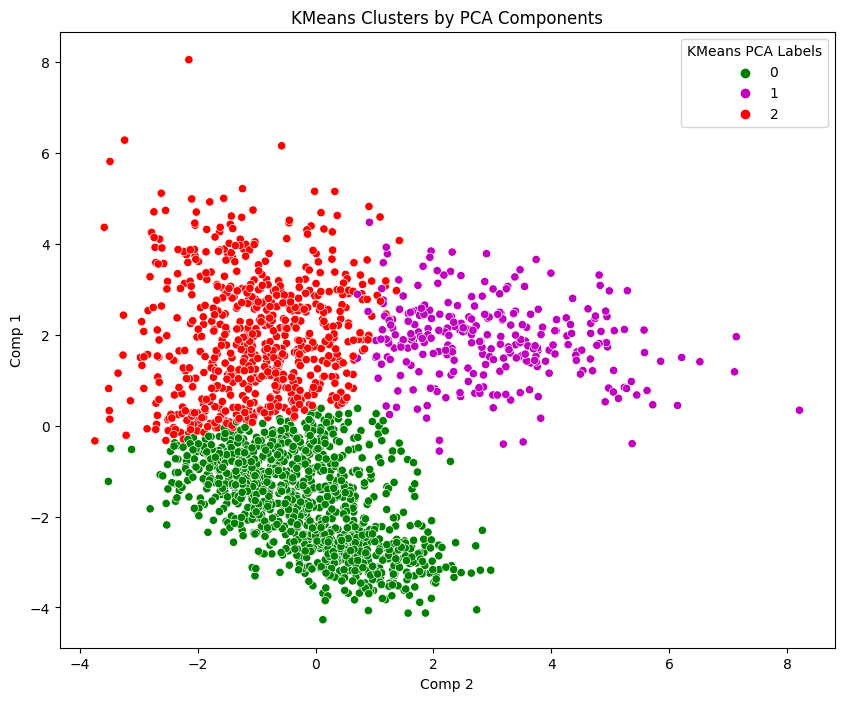

In [160]:
# Plot Kmeans clusters
x_axis = df_segm_pca['Comp 2']
y_axis = df_segm_pca['Comp 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_pca["KMeans PCA Labels"], palette = ['g','m','r'])
plt.title('KMeans Clusters by PCA Components')
plt.show()

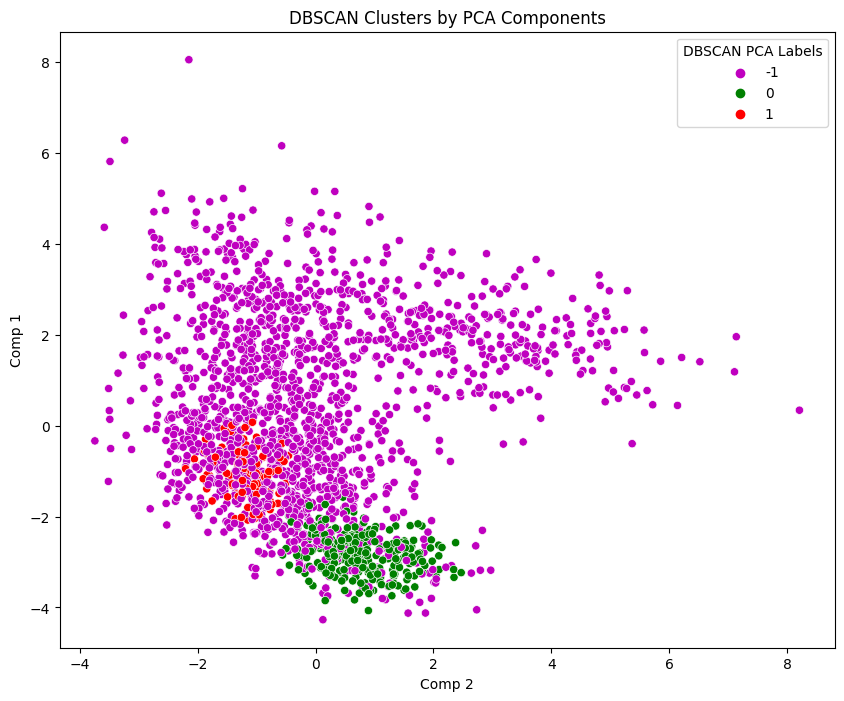

In [161]:
# Plot DBSCAN clusters
x_axis = df_segm_pca['Comp 2']
y_axis = df_segm_pca['Comp 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_pca["DBSCAN PCA Labels"], palette = ['m','g','r'])
plt.title('DBSCAN Clusters by PCA Components')
plt.show()

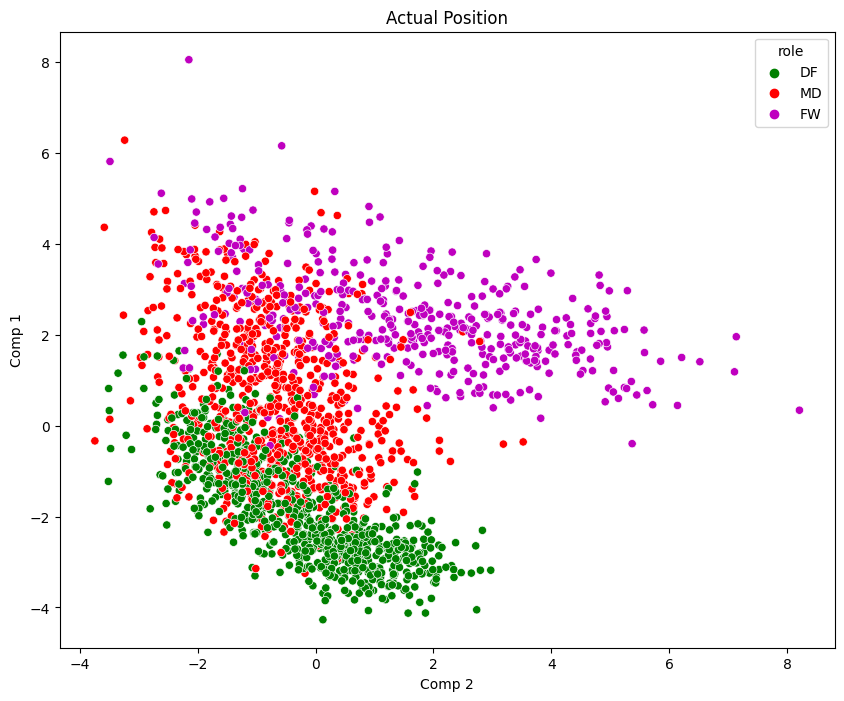

In [149]:
# Plot actual positions
x_axis = df_segm_pca['Comp 2']
y_axis = df_segm_pca['Comp 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_pca["role"], palette = ['g','r','m'])
plt.title('Actual Position')
plt.show()

In [150]:
# Replace cluster labels with position abbreviations
df_segm_pca['KMeans PCA Labels'] = df_segm_pca['KMeans PCA Labels'].map({
    0: 'DF',
    1: 'FW',
    2: 'MD'
})

df_segm_pca['DBSCAN PCA Labels'] = df_segm_pca['DBSCAN PCA Labels'].map({
    -1: 'FW',  # Typically -1 in DBSCAN represents noise points
    0: 'DF',
    1: 'MD'
})


KMEANS PCA CLUSTERING PERFORMANCE

CLASS-WISE METRICS:

DF Position:
• Precision: 0.661
• Recall:    0.901
• F1-Score:  0.763
• Support:   771.0

MD Position:
• Precision: 0.923
• Recall:    0.594
• F1-Score:  0.723
• Support:   443.0

FW Position:
• Precision: 0.608
• Recall:    0.512
• F1-Score:  0.556
• Support:   768.0

OVERALL METRICS:
• Accuracy:           0.682
• Weighted Precision: 0.699
• Weighted Recall:    0.682
• Weighted F1-Score:  0.674


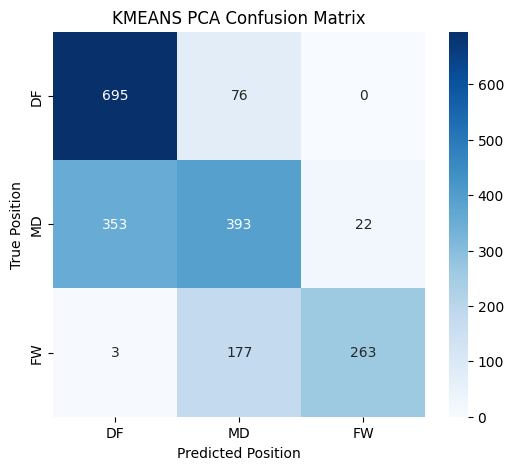


DBSCAN PCA CLUSTERING PERFORMANCE

CLASS-WISE METRICS:

DF Position:
• Precision: 0.970
• Recall:    0.333
• F1-Score:  0.496
• Support:   771.0

MD Position:
• Precision: 0.275
• Recall:    1.000
• F1-Score:  0.432
• Support:   443.0

FW Position:
• Precision: 0.056
• Recall:    0.008
• F1-Score:  0.014
• Support:   768.0

OVERALL METRICS:
• Accuracy:           0.356
• Weighted Precision: 0.460
• Weighted Recall:    0.356
• Weighted F1-Score:  0.295


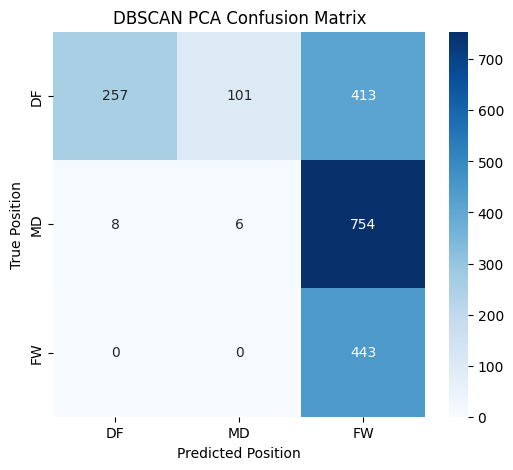

In [151]:
# Function to print metrics in simple format
def print_simple_metrics(true_labels, pred_labels, method_name):
    print(f"\n{'='*50}")
    print(f"{method_name} CLUSTERING PERFORMANCE")
    print('='*50)
    
    # Calculate all metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, 
                                 target_names=['DF', 'MD', 'FW'], 
                                 output_dict=True, zero_division = 0)
    
    # Print class-wise metrics
    print("\nCLASS-WISE METRICS:")
    for pos in ['DF', 'MD', 'FW']:
        print(f"\n{pos} Position:")
        print(f"• Precision: {report[pos]['precision']:.3f}")
        print(f"• Recall:    {report[pos]['recall']:.3f}")
        print(f"• F1-Score:  {report[pos]['f1-score']:.3f}")
        print(f"• Support:   {report[pos]['support']}")
    
    # Print overall metrics
    print("\nOVERALL METRICS:")
    print(f"• Accuracy:           {accuracy:.3f}")
    print(f"• Weighted Precision: {report['weighted avg']['precision']:.3f}")
    print(f"• Weighted Recall:    {report['weighted avg']['recall']:.3f}")
    print(f"• Weighted F1-Score:  {report['weighted avg']['f1-score']:.3f}")
    
    # Create and display confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=['DF', 'MD', 'FW'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['DF', 'MD', 'FW'],
                yticklabels=['DF', 'MD', 'FW'])
    plt.title(f'{method_name} Confusion Matrix')
    plt.ylabel('True Position')
    plt.xlabel('Predicted Position')
    plt.show()

# Evaluate and print results for both methods
print_simple_metrics(df_segm_pca['role'],
                   df_segm_pca['KMeans PCA Labels'],
                   "KMEANS PCA")

print_simple_metrics(df_segm_pca['role'],
                   df_segm_pca['DBSCAN PCA Labels'],
                   "DBSCAN PCA")

## Discussion of Clustering Results

Looking at the results above, K-Means had better performance, but neither did well. K-Means was able to locate the general area of all three clusters, but was unable to determine specific nuances or relationships that differentiated overlapping samples. On the other hand, DBScan tended to classify every point as either forward or defender depending on the eps chosen, indicating that there is little to differentiate between the density of all the samples. In fact, many of the points were classified as noise. In both cases, the model had difficulty distinguishing midfielders from forwards and defenders. This makes sense as midfielders span a larger range of defending/attacking roles. 

## Mapping Algorithm

Now, we experiment with more unsupervised methods like the Mapper Algorithm. The Mapper Algorithm is a Topological Data Analysis technique that utilizes a combination of dimensionality reduction and clustering to create a graphical representation of the data. Nodes represent similar groups and edges are created between nodes when one or more members is shared between them. It can sometimes uncover hidden relationships or potential subgroups that might not be apparent through traditional dimensionality reduction or clustering methods alone.

In [31]:
# Create mapper object
mapper = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


In [32]:
# Project data from original parameter space to 2 dimensional space using UMAP
projected_data = mapper.fit_transform(train, projection=[manifold.Isomap(n_components=100, n_jobs=-1), umap.UMAP(min_dist = 0.01, n_components=2,random_state=42, metric = 'cosine')])

..Composing projection pipeline of length 2:
	Projections: Isomap(n_components=100, n_jobs=-1)
		UMAP(metric='cosine', min_dist=0.01, random_state=42)
	Distance matrices: False
False
	Scalers: MinMaxScaler()
MinMaxScaler()
..Projecting on data shaped (1982, 15)

..Projecting data using: 
	Isomap(n_components=100, n_jobs=-1)


..Scaling with: MinMaxScaler()

..Projecting on data shaped (1982, 100)

..Projecting data using: 
	UMAP(metric='cosine', min_dist=0.01, random_state=42, verbose=1)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_jobs=1, random_state=42, verbose=1)
Thu Aug 14 21:06:53 2025 Construct fuzzy simplicial set


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Thu Aug 14 21:06:54 2025 Finding Nearest Neighbors
Thu Aug 14 21:06:55 2025 Finished Nearest Neighbor Search
Thu Aug 14 21:06:56 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Aug 14 21:06:59 2025 Finished embedding

..Scaling with: MinMaxScaler()



In [74]:
# cluster data using DBSCAN
G = mapper.map(projected_data, train, clusterer=sklearn.cluster.DBSCAN(metric="correlation", eps = 8, min_samples = 25))

Mapping on data shaped (1982, 15) using lens shaped (1982, 2)

Creating 100 hypercubes.

Created 81 edges and 50 nodes in 0:00:00.055645.


In [75]:
# define an excessively long filename (helpful if saving multiple Mapper variants for single dataset)
fileID = 'projection=' + G['meta_data']['projection'].split('(')[0] + '_' + \
'n_cubes=' + str(G['meta_data']['n_cubes']) + '_' + \
'perc_overlap=' + str(G['meta_data']['perc_overlap']) + '_' + \
'clusterer=' + G['meta_data']['clusterer'].split('(')[0] + '_' + \
'scaler=' + G['meta_data']['scaler'].split('(')[0]

In [162]:
# visualize graph
mapper.visualize(G, 
                path_html= "mapper_example_" + fileID + ".html",
                title=fileID,
                custom_tooltips = np.array(final_df['shortName']),
                color_values = final_df['playerankScore'],
                color_function_name = 'Player Rank Scores',
                node_color_function = np.array(['average', 'std', 'sum', 'max', 'min']))

# display mapper in jupyter
km.jupyter.display("mapper_example_" + fileID + ".html")

Wrote visualization to: mapper_example_projection=UMAP_n_cubes=10_perc_overlap=0.1_clusterer=DBSCAN_scaler=MinMaxScaler.html


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/kmapper/visuals.py:344: RuntimeWarning: invalid value encountered in scalar divide
  height = np.floor(((bar / max_bucket_value) * 100) + 0.5)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/kmapper/visuals.py:345: RuntimeWarning: invalid value encountered in scalar divide
  perc = round((bar / sum_bucket_value) * 100.0, 1)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Discussion of Mapper Algorithm

The above mapper algorithm describes the data and the groups within them much more clearly. The graph seems to resemble a spiral shape. It is clear to see that the bottom leg of the spiral contains clusters of relatively more "defensive players", like center backs or defensive midfielders, whose main roles are winning the ball back and protecting the goal. As we travel further up the arm, the players become slightly more offensive and well rounded, this is where we find "do it all midfielders". This is where the paths diverge, towards the top right of the map, the area is occupied by full backs who typically have more attacking duties while also having to play a role in the defending. If we follow the path to the left we come across more attacking midfielders and wingers. This is where we find the likes of Lionel Messi, Neymar and Philippe Coutinho. Furthest from where we started are players with no defensive responsibilites at all, our strikers. The edges are occupied by traditional center forward "target men" like Christian Benteke, Olivier Giroud and Peter Crouch. 

## Classification Models

Now, an interesting follow-up would be to see how well a "supervised" model could perform. Thus, we attempt to build a Random Forest and a Neural Network to classify our data.

In [164]:
final_df.head()

,playerId,minutesPlayed,playerankScore,airDuels_per90,groundDefendingDuels_per90,takeOnDuels_per90,groundLooseBallDuels_per90,accelerations_per90,interceptions_per90,crosses_per90,goalKicks_per90,longPasses_per90,shortPasses_per90,smartPasses_per90,shots_per90,clearances_per90,shortName,role,height
2,36,2160.0,0.008550,3.62,5.08,1.33,2.08,0.08,6.25,0.58,0.0,10.08,53.67,0.29,0.88,2.46,T. Alderweireld,DF,187
3,38,347.0,0.001000,4.93,8.56,2.85,2.59,0.26,4.93,3.89,0.0,6.48,47.46,0.26,0.78,1.04,D. Blind,DF,180
5,48,4104.0,0.011824,5.46,5.86,2.46,2.54,0.33,5.39,0.88,0.0,5.33,55.96,0.46,0.57,2.43,J. Vertonghen,DF,189
6,54,3616.0,0.009000,1.42,4.83,7.37,3.04,0.92,5.90,2.99,0.0,4.70,47.89,2.91,2.24,0.45,C. Eriksen,MD,180
8,66,429.0,0.006057,20.35,5.87,5.87,6.08,0.00,2.94,0.21,0.0,0.21,15.10,0.21,1.05,2.10,K. Sig\u00fe\u00f3rsson,FW,186


In [37]:
# Drop unnecessary columns
data = final_df.drop(['playerId','minutesPlayed','playerankScore','shortName'], axis = 1)

# Initialize encoder
encoder = LabelEncoder()

# Fit and transform the 'role' column
data['role'] = encoder.fit_transform(data['role'])  # +1 to get (1,2,3 instead of 0,1,2)

In [38]:
X = data.drop(['role'], axis = 1)
y = data['role']

In [39]:
# Standardize our features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [40]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2
)

In [41]:
# Helper functions
def trainModel(model, X_train, X_test, y_train, param_grid):
    """
    Trains a model using GridSearchCV on the specified feature columns of the training data,
    then prints the best parameters and returns the best model found.

    Parameters
    ----------
    model : estimator class
        A scikit-learn estimator class (e.g., RandomForestClassifier).
        Note that this should be passed as a class, not an instance.
    X_train : pd.DataFrame
        The training data.
    X_test : pd.DataFrame
        The testing data (used here only for feature selection, not evaluation).
    y_train : pd.Series
        The training labels.
    param_grid : dict
        A dictionary specifying the parameter names and lists of settings
        to try in GridSearchCV.

    Returns
    -------
    best_model : estimator instance
        The best estimator found by GridSearchCV.
    """

    model = model(random_state = 42)

    # Set up a 5-fold cross-validation grid search
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
    # Fit the model on the selected training features
    grid_search.fit(X_train, y_train)

    # Print the best parameter combination found by grid search
    print("Best parameters found:", grid_search.best_params_)

    # Retrieve the best model from the grid search
    best_model = grid_search.best_estimator_

    return best_model

def testModel(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the given trained model and prints comprehensive performance metrics.
    
    Parameters
    ----------
    model : estimator instance
        A trained scikit-learn model or pipeline.
    X_train : pd.DataFrame
        The training features.
    y_train : pd.Series
        The training labels.
    X_test : pd.DataFrame
        The testing features.
    y_test : pd.Series
        The testing labels.
    
    Returns
    -------
    None
        Prints evaluation metrics but doesn't return anything.
    """
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for training set
    train_metrics = {
        'Accuracy': model.score(X_train, y_train),
        'Precision': precision_score(y_train, y_train_pred, average='weighted'),
        'Recall': recall_score(y_train, y_train_pred, average='weighted'),
        'F1-Score': f1_score(y_train, y_train_pred, average='weighted')
    }
    
    # Calculate metrics for test set
    test_metrics = {
        'Accuracy': model.score(X_test, y_test),
        'Precision': precision_score(y_test, y_test_pred, average='weighted'),
        'Recall': recall_score(y_test, y_test_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    # Print formatted results
    print("\n" + "="*50)
    print("Model Performance Evaluation")
    print("="*50)
    print(f"{'Metric':<15}{'Training':>15}{'Testing':>15}")
    for metric in train_metrics:
        print(f"{metric:<15}{train_metrics[metric]:>15.3f}{test_metrics[metric]:>15.3f}")
    print("="*50)
    
    # Print detailed classification report
    print("\nDetailed Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
def confusionMatrix(model, X_test, y_test, display_labels=None):
    """
    Plots a confusion matrix for the given model and test data.

    Parameters
    ----------
    model : estimator instance
        A fitted scikit-learn model with a predict method.
    X_test : pd.DataFrame
        The features for the test set.
    y_test : pd.Series
        The true labels for the test set.
    display_labels : list of str, optional
        The labels to display in the confusion matrix. Defaults to
        ["Adelie", "Chinstrap", "Gentoo"] if None is provided.

    Returns
    -------
    None
        Displays the confusion matrix plot.
    """
    # Default label names if none are provided
    if display_labels is None:
        display_labels = ["DF", "MD", "FW"]

    # Create a confusion matrix display using the estimator
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=display_labels,
        cmap=plt.cm.Blues
    )

    # Set a title and show the plot
    disp.ax_.set_title("Confusion Matrix")
    plt.show()

In [45]:
# Construct parameter grid to search over
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Train model to obtain optimal parameters
best_rf = trainModel(RandomForestClassifier, X_train, X_test, y_train, rf_param_grid)

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [46]:
# Test and output peformance metrics
testModel(best_rf, X_train, y_train, X_test, y_test)


Model Performance Evaluation
Metric                Training        Testing
Accuracy                 1.000          0.856
Precision                1.000          0.856
Recall                   1.000          0.856
F1-Score                 1.000          0.856

Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       142
           1       0.82      0.81      0.82        90
           2       0.84      0.82      0.83       165

    accuracy                           0.86       397
   macro avg       0.85      0.85      0.85       397
weighted avg       0.86      0.86      0.86       397



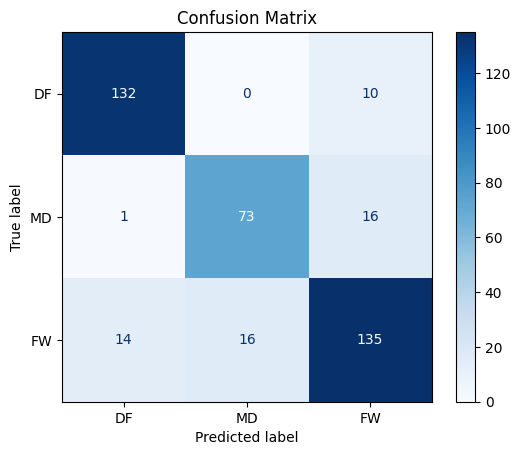

In [47]:
# Output confusion matrix for RF results
confusionMatrix(best_rf, X_test, y_test)

In [48]:
class SimpleDNN(nn.Module):
    """A simple fully connected neural network with configurable depth.
    
    Args:
        input_dim (int): Size of input features
        output_dim (int): Size of output
        hidden_dims (list): List of hidden layer dimensions
        activation (nn.Module): Activation function to use (default: ReLU)
        dropout (float): Dropout probability (default: 0.0)
        output_activation (nn.Module): Optional activation for output layer
    """
    def __init__(self, input_dim, output_dim, hidden_dims=[64,128,64], activation=nn.LeakyReLU(0.1),
                 use_batchnorm=True, dropout=0.0, output_activation=None):
        super().__init__()
        
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        
        # Create hidden layers
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            # Normalization
            if use_batchnorm and dims[i+1] > 1:  # BN requires >1 features
                layers.append(nn.BatchNorm1d(dims[i+1]))
            elif use_layernorm:
                layers.append(nn.LayerNorm(dims[i+1]))
            if i < len(dims)-2:  # Not last layer
                layers.append(activation)
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))
        
        # Add output activation if specified
        if output_activation is not None:
            layers.append(output_activation)
            
        self.net = nn.Sequential(*layers)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        return self.net(x)
    
def evaluate_classifier(model, data_loader, device='cpu', class_names=None):
    """
    Evaluates a PyTorch model and outputs metrics + confusion matrix
    
    Args:
        model: PyTorch model
        data_loader: DataLoader containing test/val data
        device: 'cuda' or 'cpu'
        class_names: List of class names for visualization
    
    Returns:
        Dictionary containing metrics and confusion matrix
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Generate metrics
    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_targets, all_preds)
    
    # Convert to DataFrame for better visualization
    cm_df = pd.DataFrame(cm, 
                         index=class_names if class_names else [f'Class {i}' for i in range(cm.shape[0])],
                         columns=class_names if class_names else [f'Class {i}' for i in range(cm.shape[1])])
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    # Return comprehensive metrics
    metrics = {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score'],
        'confusion_matrix': cm,
        'class_report': report
    }
    
    return metrics

In [49]:
# Convert into tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y.values).long()

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

# Create DataLoader for mini-batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [56]:
# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify loss function
criterion = nn.CrossEntropyLoss()

# Specify number of epochs
num_epochs = 10

# Initialize k-fold
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store results
fold_results = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"\nFold {fold + 1}/{k_folds}")
    
    # Create subset dataloaders
    train_subset = Subset(TensorDataset(X_tensor, y_tensor), train_idx)
    val_subset = Subset(TensorDataset(X_tensor, y_tensor), val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # Reinitialize model for each fold
    model = SimpleDNN(
        input_dim=X_tensor.shape[1],
        hidden_dims=[64, 128, 64],
        output_dim=len(torch.unique(y_tensor)),
        dropout=0.2
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop for this fold
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
        
        # Validation for this fold
        model.eval()
        val_loss, correct = 0.0, 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item() * batch_X.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == batch_y).sum().item()
        
        # Store and print
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        
        fold_results['train_loss'].append(train_loss)
        fold_results['val_loss'].append(val_loss)
        fold_results['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Calculate average performance across folds
avg_val_acc = np.mean(fold_results['val_acc'][-k_folds:])  # Last epoch of each fold
print(f"\nAverage Validation Accuracy across {k_folds} folds: {avg_val_acc:.4f}")


Fold 1/5
Epoch 1/10 | Train Loss: 0.8495 | Val Loss: 0.5457 | Val Acc: 0.8338
Epoch 2/10 | Train Loss: 0.5979 | Val Loss: 0.4879 | Val Acc: 0.8690
Epoch 3/10 | Train Loss: 0.5512 | Val Loss: 0.4462 | Val Acc: 0.8816
Epoch 4/10 | Train Loss: 0.5110 | Val Loss: 0.4227 | Val Acc: 0.8866
Epoch 5/10 | Train Loss: 0.4846 | Val Loss: 0.4016 | Val Acc: 0.8892
Epoch 6/10 | Train Loss: 0.4535 | Val Loss: 0.3833 | Val Acc: 0.8992
Epoch 7/10 | Train Loss: 0.4440 | Val Loss: 0.3658 | Val Acc: 0.8967
Epoch 8/10 | Train Loss: 0.4382 | Val Loss: 0.3579 | Val Acc: 0.8967
Epoch 9/10 | Train Loss: 0.4380 | Val Loss: 0.3513 | Val Acc: 0.9018
Epoch 10/10 | Train Loss: 0.4133 | Val Loss: 0.3414 | Val Acc: 0.9043

Fold 2/5
Epoch 1/10 | Train Loss: 0.7227 | Val Loss: 0.5653 | Val Acc: 0.8136
Epoch 2/10 | Train Loss: 0.5413 | Val Loss: 0.5098 | Val Acc: 0.8489
Epoch 3/10 | Train Loss: 0.5153 | Val Loss: 0.4744 | Val Acc: 0.8690
Epoch 4/10 | Train Loss: 0.4765 | Val Loss: 0.4608 | Val Acc: 0.8514
Epoch 5/10 | 

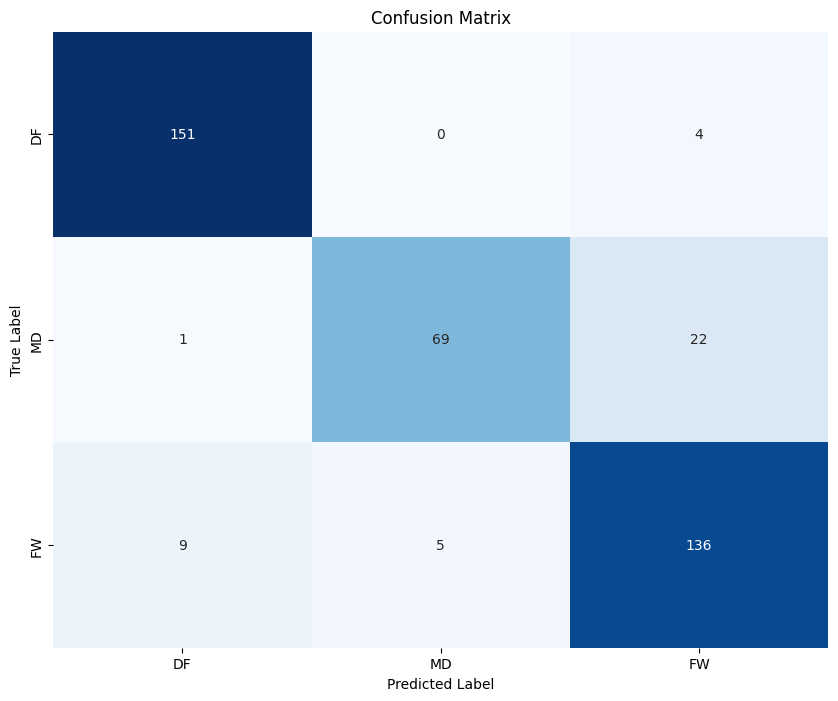


Classification Report:
              precision    recall  f1-score   support

          DF       0.94      0.97      0.96       155
          MD       0.93      0.75      0.83        92
          FW       0.84      0.91      0.87       150

    accuracy                           0.90       397
   macro avg       0.90      0.88      0.89       397
weighted avg       0.90      0.90      0.90       397



In [59]:
# Output performance metrics and confusion matrix
metrics = evaluate_classifier(
    model=model,
    data_loader=test_loader,
    device=device,
    class_names= ['DF','MD','FW']  # Optional
)

## Discussion

The two models were chosen as they perform well on complicated data. In the end, Random Forest was able to achieve a final accuracy score of 0.86, while our neural network was able to attain an accuracy of 0.90. As expected, the models performed best on the 'DF' and 'FW' classes, with precision and recall scores over 0.84. The neural network performed slightly better on the 'FW' (0.91) class when it came to recall, and much better with precision for the 'MD' class (0.93), as compared to the Random Forest's respective values of 0.82. Both models had trouble with the 'MD' class, which was expected through our clustering and visualization of the principal components as there was high levels of overlap. Additionally, the dataset was slightly imbalanced which may have played a part in the final results.